# **1.Problem:**
>
> **Regression Problem :**
>
>> Suggest product prices to online sellers? 
>
>>predict the sale price of a listing based on information a user provides for this listing. 
>
>>**Regression problem 
metrics :** mse , rmse
>
> **Steps :**
>
>>Collecting data
>
>>Run ml model
>
>>Make predictions
>


# **Data Description:**

>> train.tsv, test.tsv
>
>> The files consist of a list of product listings. These files are tab-delimited.
>
>> ## **Data fields:**
>
>> **train_id or test_id** - the id of the listing
>
>> **name** - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. 20 dollar) to avoid leakage. These removed prices are represented as [rm]
>
>> **item_condition_id** - the condition of the items provided by the seller
>
>> **category_name** - category of the listing
>
>> **brand_name**
>
>> **price** - the price that the item was sold for. **This is the target variable that you will predict** . The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
>
>> **shipping** - 1 if shipping fee is paid by seller and 0 by buyer
>
>> **item_description** - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

# **Setup:**

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
IMAGES_PATH = PROJECT_ROOT_DIR

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# **Import nedded packages:**

In [ ]:
import pandas as pd
import numpy as np
import os

from nltk.corpus import stopwords
import string

# example of random undersampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler


# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from keras.utils import to_categorical


from keras import models
from keras import layers


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle

from tensorflow.keras.models import load_model
from keras.models import model_from_json
import os


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Install Kaggle API
!pip install --quiet kaggle


if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle

# !mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_json/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

############################################
!sudo apt-get install p7zip-full




Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


# **2.Get the data:**


In [ ]:
# Get the dataset
!kaggle competitions download -c mercari-price-suggestion-challenge
!7za x train.tsv.7z

  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 64.3MB/s]
 64% 5.00M/7.77M [00:00<00:00, 45.2MB/s]
100% 7.77M/7.77M [00:00<00:00, 49.2MB/s]
 87% 65.0M/74.3M [00:00<00:00, 61.1MB/s]
100% 74.3M/74.3M [00:00<00:00, 95.4MB/s]
 56% 19.0M/34.0M [00:00<00:00, 41.6MB/s]
100% 34.0M/34.0M [00:00<00:00, 75.5MB/s]
 95% 279M/294M [00:03<00:00, 85.7MB/s]
100% 294M/294M [00:03<00:00, 81.4MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  7% - train.tsv                 11% - t

In [ ]:
df = pd.read_csv("train.tsv", sep='\t')

# **3.Discover and visualize the data to gain insights.**


#### 1- Explore data

In [ ]:
df.sample(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
777341,777341,F/ship 4 Totoro Washi + 1 pen,1,Handmade/Paper Goods/Stationery,NaN,12.0,1,This listing is for all 4 Totoro washi tape fo...
1463629,1463629,UCLA Men's Bundle + Shorts,1,Women/Other/Other,Adidas,76.0,1,7 items. 1: XL. 2: 2XL. 3:2XL. 4: XL. 5: 2XL. ...
350669,350669,Listing for lol,1,Beauty/Makeup/Lips,NaN,12.0,1,- sunglasses and necklace :)
310222,310222,25 pcs kawaii sticker flakes,1,Kids/Toys/Arts & Crafts,NaN,3.0,1,I ordered a bunch of stickers so you will reci...
759257,759257,Chanel Mini Lipgloss Set,2,Beauty/Makeup/Lips,Chanel,30.0,1,Brand new never used authentic Mini Lipgloss g...
288846,288846,Maroon Foamposites,3,Men/Shoes/Fashion Sneakers,Nike,225.0,1,9/10 Condition N Sz 12
1178450,1178450,INC studdedHeart Black Blouse Dolman,2,Women/Tops & Blouses/Blouse,INC International Concepts,16.0,1,New without tags INC International Concepts Sh...
726296,726296,Leggo silicone molds,3,Home/Kitchen & Dining/Bakeware,NaN,12.0,0,I used these for my son's leggo birthday party...
840510,840510,Supreme Uzi Chain,1,Handmade/Accessories/Men,NaN,15.0,1,10/10 New
1473033,1473033,Women Gold Palm Pendant Necklace FC,1,Vintage & Collectibles/Jewelry/Necklace,NaN,17.0,1,High quality Immediate purchase Ok? Free shipp...


> **Comments:**
>
>> 1- 
we have to cleanisng any text data at the first , most of the columns contains special characters and emojies
>
>> 2- then we have to check unique values in each column 

#### 2- Check the number of unique values in data.

In [ ]:
#check for the number of unique values in each column
df.iloc[:, :].nunique()

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64

> **Comments:**
>
>> 1- we can check them again after cleansing
>
>> 2- onehot encoding item ocndition_id , category name , brand name 

#### 3- Check For Duplicates

In [ ]:
#check for duplicates
sum(df.duplicated())

0

> **Comments:**
>
>> there is no duplicates in the data


#### 4- Check for number of Null Values in each column

In [ ]:
#check for null values in a dataset
df.iloc[:, :].isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

> **Comments:**
>
>> 1- category_name contains 6,327 null values out of 1,482,535
>
>> 2- brand_name contains  632,682 null values out of 1,482,535

let's check these null values and try to fill them based on another information first 


# **4.Prepare the data for Machine Learning algorithms.**


data cleansing

imputation 

splitting



In [ ]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### Data Pre Processing

In [ ]:
#removing special characters
df['name'] = df['name'].str.encode('ascii', 'ignore').str.decode('ascii')
df['category_name'] = df['category_name'].str.encode('ascii', 'ignore').str.decode('ascii')
df['brand_name'] = df['brand_name'].str.encode('ascii', 'ignore').str.decode('ascii')
df['item_description'] = df['item_description'].str.encode('ascii', 'ignore').str.decode('ascii')


#lower case all letters
df['name'] = df['name'].str.lower()
df['category_name'] = df['category_name'].str.lower()
df['brand_name'] = df['brand_name'].str.lower()
df['item_description'] = df['item_description'].str.lower()


#lower case all letters
df['name'] = df['name'].str.replace(r'[^\w\s]+', ' ')
df['category_name'] = df['category_name'].str.replace(r'[^\w\s]+', ' ')
df['brand_name'] = df['brand_name'].str.replace(r'[^\w\s]+', ' ')
df['item_description'] = df['item_description'].str.replace(r'[^\w\s]+', ' ')

#### check again number of unique values 

In [ ]:
#check for the number of unique values in each column
df.iloc[:, :].nunique()

train_id             1482535
name                 1133048
item_condition_id          5
category_name           1287
brand_name              4807
price                    828
shipping                   2
item_description     1269061
dtype: int64

#### Data Imputation

In [ ]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

filling nulls by predicting th enulls values in the column of category name and brand name using the rest of the values

In [ ]:
# law feh product malhoush wala category feha null mesh hanakhdouh m3ana fel e3tbar
result_1 = df.groupby(['name'])['category_name'].apply(lambda x: x.isnull().sum())

In [ ]:
#dool keda asamy el categories ely etla2a feha ya null wa7da ya aktaar 
names_of_products_1 = result_1[result_1 >0].index
print("Names of products 1: ",len(names_of_products_1))# e3rafly gowa kol product , feh kam brand feha nulls gowa
# law feh product malhoush wala brand feha null mesh hanakhdouh m3ana fel e3tbar
result_2 = df.groupby(['name'])['brand_name'].apply(lambda x: x.isnull().sum())

names_of_products_2 = result_2[result_2 >0].index
print("Names of products 2: ",len(names_of_products_2))

Names of products 1:  6088


In [ ]:
products_List= list(set(names_of_products_1) | set(names_of_products_2))
print(len(products_List))

df_selected = df[df['name'].isin(products_List)]

Names of products 2:  520877
523154


In [ ]:
del result_1
del result_2
del names_of_products_1
del names_of_products_2
del df

label encoding some the "name feature"

In [ ]:
#label encoding
Labelencoder = LabelEncoder()
encoder = OrdinalEncoder()

# Encoding data
df_selected["item_condition_id"] = encoder.fit_transform(df_selected["item_condition_id"].values.reshape(-1, 1))

numeric_f = ["price"]
df_selected[numeric_f] = df_selected[numeric_f].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

pickle.dump( df_selected, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected2.p", "wb" ) )

In [ ]:
#import data
df_selected = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected2.p", 'rb')) #load bac

In [ ]:
#split_data
list1 = df_selected[df_selected['category_name'].notna()].sample(20000, random_state=10).index

In [ ]:
list2 = df_selected[df_selected['category_name'].isna()].index


list1 = list1.tolist()
list2 = list2.tolist()
list3= list(set(list2) | set(list1))

print(len(list1))
print(len(list2))
print(len(list3))

df_selected_new = df_selected.loc[list3,:]

del df_selected

df_selected_new = pd.get_dummies(df_selected_new, columns=["name"], prefix=["name_is"])

20000
6327
26327


In [ ]:
pickle.dump( df_selected_new, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected_new.p", "wb" ) )

#import data
#df_selected_sample = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected_sample.p", 'rb')) #load bac

In [ ]:
#split_data
df_p_category_train = df_selected_new[df_selected_new['category_name'].notna()]
df_p_category_test = df_selected_new[df_selected_new['category_name'].isna()]

pickle.dump( df_p_category_train, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_train.p", "wb" ) )
pickle.dump( df_p_category_test, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test.p", "wb" ) )

In [ ]:
#import data
#df_p_category_train = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_train.p", 'rb')) #load bac
#df_p_category_test = pickle.load( open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test.p", 'rb')) #load bac

In [ ]:
#label encoding
Labelencoder = LabelEncoder()
encoder = OrdinalEncoder()

df_p_category_train["category_name_num"] = Labelencoder.fit_transform(df_p_category_train["category_name"])

look_up_table_1 = df_p_category_train[["train_id", "category_name", "category_name_num", "item_description" ]]

pickle.dump( look_up_table_1, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/look_up_table_1.p", "wb" ) )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#import data
#look_up_table_1 = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/look_up_table_1.p", 'rb')) #load bac

df_p_category_train = df_p_category_train.drop(columns=[ "train_id","item_description" , "category_name","brand_name"])
df_p_category_test =  df_p_category_test.drop( columns=[ "train_id","item_description" , "category_name","brand_name"])


train_category_X = df_p_category_train.iloc[:,:-1].values
#train_category_X = scipy.sparse.csr_matrix(df_p_category_train.iloc[:,:-1].values)
pickle.dump( train_category_X, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/train_category_X.p", "wb" ) )

train_category_y = df_p_category_train["category_name_num"].values
pickle.dump( train_category_y, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/train_category_y.p", "wb" ) )

test_category_X =  df_p_category_test.values
pickle.dump( test_category_X, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/test_category_X.p", "wb" ) )
#test_category_y =


#pickle.dump( test_category_X, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/test_category_X.p", "wb" ) )

In [ ]:
print(df_p_category_train.shape)
print(df_p_category_test.shape)

df_p_category_train["category_name_num"].nunique()

print(df_p_category_train.shape)

print(train_category_X.shape)
print(train_category_y.shape)
print(test_category_X.shape)



train_category_y = to_categorical(train_category_y)
test_category_y = 0


print(len(train_category_y))


print(train_category_X.shape)
print(train_category_y.shape)

pickle.dump( train_category_y, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/train_category_y.p", "wb" ) )

pickle.dump( df_p_category_train, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_train.p", "wb" ) )
pickle.dump( df_p_category_test, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test.p", "wb" ) )
pickle.dump( df_selected_new, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected_new.p", "wb" ) )
pickle.dump( look_up_table_1, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/look_up_table_1.p", "wb" ) )

(20000, 23715)
(6327, 23714)
(20000, 23715)
(20000, 23714)
(20000,)
(6327, 23714)
20000
(20000, 23714)
(20000, 790)


In [ ]:
del df_p_category_train
del df_p_category_test
del df_selected_new
del look_up_table_1

In [ ]:
network1 = models.Sequential()
network1.add(layers.Dense(512, activation='relu', name='Layer_1', input_shape=(23714,)))
network1.add(layers.Dense(512, activation='relu', name='Layer_2'))
network1.add(layers.Dense(512, activation='relu', name='Layer_3'))
network1.add(layers.Dense(512, activation='relu', name='Layer_4'))
network1.add(layers.Dense(512, activation='relu', name='Layer_5'))
network1.add(layers.Dense(512, activation='relu', name='Layer_6'))
network1.add(layers.Dense(790, activation = 'softmax'))  # this is the output layer
print(network1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 512)               12142080  
_________________________________________________________________
Layer_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
Layer_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
Layer_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
Layer_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
Layer_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 790)              

In [ ]:
network1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
del all_variables

NameError: ignored

In [ ]:
network1.fit(train_category_X, train_category_y , epochs=50, batch_size=128)

Epoch 1/50
157/157 [==============================] - 29s 179ms/step - loss: 5.7964 - accuracy: 0.0280
Epoch 2/50
157/157 [==============================] - 28s 179ms/step - loss: 5.2705 - accuracy: 0.0459
Epoch 3/50
157/157 [==============================] - 28s 180ms/step - loss: 4.7850 - accuracy: 0.0538
Epoch 4/50
157/157 [==============================] - 28s 181ms/step - loss: 4.4014 - accuracy: 0.0815
Epoch 5/50
157/157 [==============================] - 28s 181ms/step - loss: 4.0670 - accuracy: 0.1057
Epoch 6/50
157/157 [==============================] - 28s 180ms/step - loss: 3.7344 - accuracy: 0.1509
Epoch 7/50
157/157 [==============================] - 29s 182ms/step - loss: 3.3711 - accuracy: 0.2055
Epoch 8/50
157/157 [==============================] - 29s 182ms/step - loss: 3.0469 - accuracy: 0.2643
Epoch 9/50
157/157 [==============================] - 28s 181ms/step - loss: 2.7073 - accuracy: 0.3394
Epoch 10/50
157/157 [==============================] - 28s 181ms/step - l

In [ ]:
# serialize model to JSON
model_json = network1.to_json()
with open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/network1.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
network1.save_weights("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/network1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#network1=load_model("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/network1.h5")

In [ ]:
#import data
df_p_category_test = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test.p", 'rb')) #load bac
look_up_table_1 = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/look_up_table_1.p", 'rb')) #load bac



# evaluate the model
scores = network1.evaluate(train_category_X, train_category_y, verbose=0)
print("%s: %.2f%%" % (network1.metrics_names[1], scores[1]*100))


del scores

del train_category_X 
del train_category_y

accuracy: 93.20%


In [ ]:
df_p_category_test["predicted_category_name"]= ""
for i in range(df_p_category_test.shape[0]):
  row = test_category_X[i]
  predictd_value = np.argmax(network1.predict(np.reshape(row, (1,23714))))
  df_p_category_test.iloc[i,-1] = look_up_table_1.loc[look_up_table_1.category_name_num == predictd_value, 'category_name'].unique()[0]

pickle.dump( df_p_category_test, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test_predicted.p", "wb" ) )


In [ ]:
#pickle.dump( df_selected_new, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected_new.p", "wb" ) )

In [ ]:
import pickle
df_selected_new = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_selected_new.p", 'rb')) #load bac
#df_p_category_test = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df_p_category_test_predicted.p", 'rb')) #load bac

In [ ]:
# dropping duplicate values
df_p_category_test.drop_duplicates(keep=False,inplace=True)

In [ ]:
list1 = df_selected_new.columns
list1=list1.drop(['train_id','category_name','brand_name','item_description'])
list1=list1.tolist()

In [ ]:
list2 = df_p_category_test.columns
list2 = list2.drop(['predicted_category_name'])
list2 = list2.tolist()

In [ ]:
len(list1)

23714

In [ ]:
len(list2)

23714

In [ ]:
#del train_category_X
#del train_category_y

In [ ]:
#del test_category_X
#del look_up_table_1

In [ ]:
merged_df = df_selected_new.merge(df_p_category_test, how='left', left_on=list1, right_on=list2)

In [ ]:
import pickle
pickle.dump( merged_df, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/merged_df.p", "wb" ) )

In [ ]:
import pickle
merged_df = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/merged_df.p", 'rb')) #load bac

In [ ]:
merged_df.isnull().sum()

train_id                                        0
item_condition_id                               0
category_name                                6327
brand_name                                  19583
price                                           0
                                            ...  
name_is_zumba 4 pack dvd                        0
name_is_zumba exhilarate 7 disc package         0
name_is_zumiez cat shirts                       0
name_is_zutano hat and booties 18 months        0
predicted_category_name                     20016
Length: 23719, dtype: int64

In [ ]:
#merged_df.loc[merged_df.category_name.isnull(), 'category_name'] = merged_df.loc[merged_df.category_name.isnull(), 'predicted_category_name']

In [ ]:
merged_df.isnull().sum()

train_id                                        0
item_condition_id                               0
category_name                                6327
brand_name                                  19583
price                                           0
                                            ...  
name_is_zumba 4 pack dvd                        0
name_is_zumba exhilarate 7 disc package         0
name_is_zumiez cat shirts                       0
name_is_zutano hat and booties 18 months        0
predicted_category_name                     20016
Length: 23719, dtype: int64

In [ ]:
#merged_df = merged_df.iloc[:,:-1]

In [ ]:
merged_df.isnull().sum()

train_id                                        0
item_condition_id                               0
category_name                                6327
brand_name                                  19583
price                                           0
                                            ...  
name_is_zumba 4 pack dvd                        0
name_is_zumba exhilarate 7 disc package         0
name_is_zumiez cat shirts                       0
name_is_zutano hat and booties 18 months        0
predicted_category_name                     20016
Length: 23719, dtype: int64

In [ ]:
df.shape[0]

1482535

In [ ]:
df['train_id'][0]

0

In [ ]:
index = df[df['category_name'].isna()].index

In [ ]:
print(index)

Int64Index([    122,     155,     258,     984,    1185,    1274,    1320,
               1419,    1491,    1521,
            ...
            1480241, 1480798, 1480949, 1480995, 1481003, 1481249, 1481750,
            1482252, 1482443, 1482473],
           dtype='int64', length=6327)


In [ ]:
len(index)

6327

In [ ]:
len(df[df['category_name'].isna()].index)

6327

In [ ]:
merged_df["train_id"].shape[0]

26327

In [ ]:
for i in index:
  for e in range(merged_df["train_id"].shape[0]):
    if df["train_id"][i] == merged_df["train_id"][e]:
      df["category_name"][i]=merged_df["predicted_category_name"][e]
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name            51
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

After filling nan values with a predicted values from a neural network with accuracy , we are going to drop any other missing values in another columns , and imputing the brand feature with the same prediction solution is doable , but the sparsity of the columns of the features and the training time takes alot of time and there is alot of missing values in it and colab ram can't handel doing all of that in one active session,so just because of that reason we are going to drop the missing values from that column.
and encoding the data with the label encoder.

In [ ]:
#pickle.dump( df, open( "/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df.p", "wb" ) )

In [ ]:
import pickle
df = pickle.load( open("/content/drive/MyDrive/Machine_Learning_Assignments_datasets/assignmnet3_pickles/df.p", 'rb')) #load bac

In [ ]:
'''-----------------Drop Missing Values in Data Fram------------------'''
# drop all rows that has missing values from the data 
df.dropna(axis=0, how='any',inplace=True)

In [ ]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [ ]:
df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1,1,razer blackwidow chroma keyboard,3,electronics computers tablets components p...,razer,52.0,0,this keyboard is in great condition and works ...
2,2,ava viv blouse,1,women tops blouses blouse,target,10.0,1,adorable top with a hint of lace and a key hol...
6,6,acacia pacific tides santorini top,3,women swimwear two piece,acacia swimwear,64.0,0,size small but straps slightly shortened to fi...
7,7,girls cheer and tumbling bundle of 7,3,sports outdoors apparel girls,soffe,6.0,1,you get three pairs of sophie cheer shorts siz...
8,8,girls nike pro shorts,3,sports outdoors apparel girls,nike,19.0,0,girls size small plus green three shorts total
...,...,...,...,...,...,...,...,...
1482525,1482525,red victoria s secret bra w sequins,2,women underwear bras,pink,7.0,1,removable straps to make strapless size 34 b ...
1482528,1482528,victoria s secret tankini sz large,2,women athletic apparel sports bras,victoria s secret,18.0,1,purple and paisley victoria s secret tankini s...
1482529,1482529,men s ua rm,2,men athletic apparel shirts tops,under armour,34.0,0,rm for the set both in perfect condition no ...
1482530,1482530,free people inspired dress,2,women dresses mid calf,free people,20.0,1,lace says size small but fits medium perfectl...


now the data is ready to be used..

there are features that are not important to train our model with so we simply can remove them like: train_id, item_description

In [ ]:
df=df.iloc[:, 1:-1]

In [ ]:
df=df[["name","item_condition_id","category_name","brand_name","shipping","price"]]

In [ ]:
df.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
price                0
dtype: int64

In [ ]:
#label encoding
Labelencoder = LabelEncoder()
encoder = OrdinalEncoder()

# Encoding data
df["item_condition_id"] = encoder.fit_transform(df["item_condition_id"].values.reshape(-1, 1))
df["name"] = Labelencoder.fit_transform(df["name"])
df["category_name"] = Labelencoder.fit_transform(df["category_name"])
df["brand_name"] = Labelencoder.fit_transform(df["brand_name"])
df=df[["name"	,"item_condition_id"	,"category_name"	,"brand_name","shipping",	"price"	]]

#### Feature Scaling

In [ ]:
numeric_f = ["name"]
df[numeric_f] = df[numeric_f].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

numeric_f = ["category_name"]
df[numeric_f] = df[numeric_f].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

numeric_f = ["item_condition_id"]
df[numeric_f] = df[numeric_f].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

numeric_f = ["shipping"]
df[numeric_f] = df[numeric_f].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df["price"]=np.log1p(df["price"])

#### Feature selection

Feature selection by ExtraTreesRegressor(model based). ExtraTreesRegressor helps us find the features which are most important.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

(594876, 5)
(254948, 5)
[0.39856087 0.03415442 0.31204915 0.22388881 0.03134675]


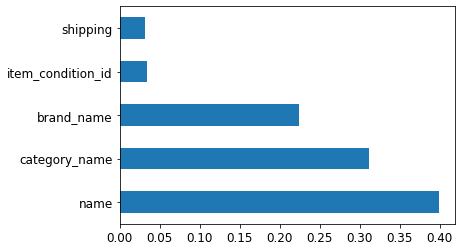

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df.iloc[:,:-1],
    df.iloc[:,-1],
    test_size=0.3,
    random_state=0)

# size of train data set
print(X_train.shape)

# size of test data set
print(X_test.shape)

reg= ExtraTreesRegressor()
reg.fit(X_train,Y_train)

#Let us print the features importance.
print(reg.feature_importances_)

feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

Based on plot above, we can select the features which will be most important for our prediction model.

**shipping** and **item condition id** are not important so we can easily ignore them

In [ ]:
#ignore shipping and item_condition_id
df=df[["name"	,"category_name"	,"brand_name",	"price"	]]

### Splitting data

In [ ]:
# Spliting our data
X = df.iloc[:, :-1] 
Y = df["price"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0) 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print("")
print(X_test.shape)
print(Y_test.shape)

(594876, 3)
(594876,)

(254948, 3)
(254948,)


# 5.Select a model and train it.


### Decision Tree Regressor

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg_decision_model = DecisionTreeRegressor()

# fit independent varaibles to the dependent variables
reg_decision_model.fit(X_train,Y_train)

print(reg_decision_model.score(X_train,Y_train))
print(reg_decision_model.score(X_test,Y_test))

# Decision Tree Model Evaluation

#Y_predict = reg_decision_model.predict(X_test)
Y_predict = np.expm1(reg_decision_model.predict(X_test))
Y_test=np.expm1(Y_test)

# without hyperparameter tuning 

from sklearn import metrics
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(Y_test, Y_predict))
print('MSE:', metrics.mean_squared_error(Y_test, Y_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predict)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y_test, Y_predict))

0.9547304306498604
0.235680400809416
MAE: 16.451538579331366
MSE: 1874.6720583849715
RMSE: 43.297483280035706
Coefficient of determination: 0.08


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


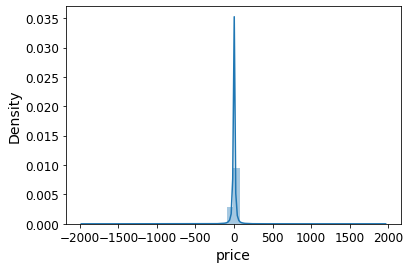

In [ ]:
# checking difference between labled y and predicted y
sns.distplot(Y_test-Y_predict)

We are getting nearly bell shape curve but that does not mean our model working good, we cant tell. Good bell curve only tell us the range of predicted values are with in the same range as our original data range values are.

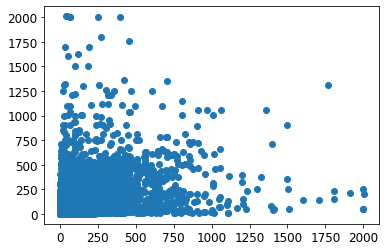

In [ ]:
#checking predicted y and labeled y using a scatter plot.
plt.scatter(Y_test,Y_predict)

# 6.Fine-tune your model.


### Hyper Parameter tuning

### using RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(DecisionTreeRegressor(), 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_absolute_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)

In [ ]:
clfrs.fit(X,Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [ ]:
clfrs.cv_results_
    
clfrs.best_params_, clfrs.best_score_

({'max_depth': 15, 'min_samples_split': 7}, -0.4327805742792111)

##### Training Decision Tree With Best Hyperparameters

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0) 

In [ ]:
tuned_hyper_model = DecisionTreeRegressor(max_depth=15, min_samples_split=7)

# fit independent varaibles to the dependent variables
tuned_hyper_model.fit(X_train,Y_train)

print(tuned_hyper_model.score(X_test , Y_test))

tuned_pred = np.expm1(tuned_hyper_model.predict(X_test))
Y_test=np.expm1(Y_test)

0.41591381060505905


In [ ]:
# With hyperparameter tuning 

from sklearn import metrics
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(Y_test, Y_predict))
print('MSE:', metrics.mean_squared_error(Y_test, Y_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predict)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y_test, Y_predict))

MAE: 14.49293166084097
MSE: 1449.9674442249784
RMSE: 38.07843804865134
Coefficient of determination: 0.29


it is better than before

Let us compare now Error rate of our model with hyper tuning of paramerters to our original model which is without the tuning of parameters.

In [ ]:
# With hyperparameter tuned 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(Y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, tuned_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y_test, tuned_pred))

MAE: 14.492088517223298
MSE: 1450.12143283781
RMSE: 38.08045998721405
Coefficient of determination: 0.29


In [ ]:
# without hyperparameter tuning 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,Y_predict))
print('MSE:', metrics.mean_squared_error(Y_test, Y_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Y_predict)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y_test, Y_predict))

MAE: 16.451538579331366
MSE: 1874.6720583849715
RMSE: 43.297483280035706
Coefficient of determination: 0.08


Conclusion
If you observe the above metrics for both the models, the error got decreased with hyperparameter tuning model compare to model without hyper parameter tuning.

# **Conclusion:**
>
>> If you observe the above metrics for both the models, the error got decreased with hyperparameter tuning model compare to model without hyper parameter tuning.
>
>> **With:**
>> 
>>**MAE:** 14.492088517223298
>>
>>**MSE:** 1450.12143283781
>>
>>**RMSE:** 38.08045998721405
>>
>>**Coefficient of determination:** 0.29
>>
>> This is the best result i got. 
